In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings('ignore')
import gc

from tqdm.notebook import tqdm
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from baseline import build_base_dataset
from m5.metric import WRMSSE
from m5.constants import *
from utils.funcs import only_days_columns
from utils.dtype import downcast
from baseline import window_stats

In [3]:
import logging
logging.basicConfig(format="[%(asctime)s] %(levelname)s: %(message)s")
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
ds = build_base_dataset()
# ds = joblib.load('data/cache/ds_with_features.jbl')
# metric = WRMSSE(ds[ds['d'] < 1914], ds[ds['d'] >= 1914], target_col='target_sold')

[2020-06-22 11:04:24,162] INFO: Use cache


In [5]:
metric = WRMSSE(ds[ds['d'] < 1914], ds[ds['d'] >= 1914])

[2020-06-22 11:05:24,620] INFO: Calculate profit
[2020-06-22 11:05:42,577] INFO: Transform train to standard view
[2020-06-22 11:07:19,106] INFO: Transform validation to standard view
[2020-06-22 11:07:19,703] INFO: Calculate levels specification
100%|██████████| 12/12 [00:56<00:00,  4.71s/it]


In [6]:
# затираем реальные продажи и цену, дабы не ликнуть данные
ds['sold'] = ds['sold'].astype(np.float32)
ds.loc[:, 'target_sold'] = ds.loc[:, 'sold']
ds.loc[ds['d'] >= 1914, 'sold'] = np.nan

ds['sell_price'] = ds['sell_price'].astype(np.float32)

# Подготовка набора данных

## Статистика по группам

In [7]:
ds_stat_features = window_stats(
    ds,
    features=['sold', 'sell_price'],
    stat_funcs=['mean', 'std'],
    levels=[
        'id',
        'item_id',
        ['state_id', 'item_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'item_id'],
        ['store_id', 'dept_id'],
    ],
    use_cache=True
)
ds_stat_features = ds_stat_features.drop(ID_COLUMNS, axis=1)
stats_feature = list(set(ds_stat_features.columns.tolist()).difference(ds.columns))

ds = pd.concat([ds, ds_stat_features], axis=1)

[2020-06-22 11:08:23,369] INFO: Use cache


In [8]:
del ds_stat_features
gc.collect()

66

## Исключение данных "до старта продаж"

In [9]:
# определяем стартпродаж по критерию - как только был продана хотяб 1 единца - старт т наступил
ds['start_of_sales'] = ds.groupby('id')['sold'].transform(lambda x: np.argmax(x > 0))
# поскольку сдвиг агрегатов у нас минимум 28 дней, то сдвинем старт продаж на этот срок
ds = ds[ds['d'] > (ds['start_of_sales'])]

In [10]:
# выделим часть данных, в которых сверхбольшое количество покупок
ds['use_for_train'] = ds['target_sold'] < 100

## Лаги

### Лаги по продажам

In [12]:
sold_lag_features = ['sold_shift_28', 'sold_shift_42', 'sold_shift_56']
cache_sold_lag_path = 'data/cache/sold_lag.jbl'

if os.path.isfile(cache_sold_lag_path):
    logging.info('Use cache.')
    sold_lag = joblib.load(cache_sold_lag_path)[sold_lag_features]
    ds = pd.concat([ds, sold_lag], axis=1)
else:
    logging.info('Re-build sold lag features.')
    group_by_id = ds.groupby('id')
    for lag in tqdm([28, 42, 56]):
        ds[f'sold_shift_{lag}'] = group_by_id['sell_price'].transform(lambda x: x.shift(lag)).astype(np.float16)
        
    logging.info(f'Save to: {cache_sold_lag_path}')
    joblib.dump(ds[ID_COLUMNS + sold_lag_features], cache_sold_lag_path)

[2020-06-22 11:13:20,427] INFO: Use cache.


In [13]:
del sold_lag
gc.collect()

22

### Лаги по ценам

In [14]:
cache_price_path = 'data/cache/price_fratures.jbl'
price_features_col = []
for lag in [1, 3, 7, 28]:
    price_features_col.append(f'price_shift_{lag}')
    price_features_col.append(f'price_diff_{lag}')

if os.path.isfile(cache_price_path):
    logging.info('Use cache.')
    price_features = joblib.load(cache_price_path)[price_features_col]
    ds = pd.concat([ds, price_features], axis=1)
else:
    logging.info('Re-building price features.')
    group_by_id = ds.groupby('id')
    for lag in tqdm([1, 3, 7, 28]):
        ds[f'price_shift_{lag}'] = group_by_id['sell_price'].transform(lambda x: x.shift(lag)).astype(np.float16)
        ds[f'price_diff_{lag}'] = group_by_id['sell_price'].transform(lambda x: x.diff(lag)).astype(np.float16)
    
    logging.info(f'Save to: {cache_price_path}')
    joblib.dump(ds[ID_COLUMNS + price_features_col], cache_price_path)

[2020-06-22 11:13:48,188] INFO: Use cache.


In [15]:
del price_features
gc.collect()

22

### Подсчет таргетов (разные лаги)

In [16]:
targets_shift_col = [f'target_{lag}' for lag in range(0, 28)]
target_lag_path = 'data/cache/target_lag.jbl'

if os.path.isfile(target_lag_path):
    logging.info('Use cache.')
    targets_shift = joblib.load(target_lag_path)[targets_shift_col]
    ds = pd.concat([ds, targets_shift], axis=1)
else:
    logging.info('Re-build sold lag features.')
    group_by_id = ds.sort_values(by='d')[['id', 'target_sold']].groupby('id')
    for lag in tqdm(range(0, 28)):
        ds[f'target_{lag}'] = group_by_id['target_sold'].transform(lambda x: x.shift(-lag))
        
    logging.info(f'Save to: {target_lag_path}')
    joblib.dump(ds[ID_COLUMNS + targets_shift_col], target_lag_path)

[2020-06-22 11:14:43,429] INFO: Use cache.


0

### Снижение размерности данных для экономии памяти

In [32]:
ds = downcast(ds)

100%|██████████| 137/137 [05:03<00:00,  2.22s/it]


In [ ]:
# joblib.dump(ds, 'data/cache/ds_with_features.jbl')

# Обучение модели

In [33]:
ds['event_type_1'] = ds['event_type_1'].cat.add_categories('NaN').fillna('NaN')
ds['event_name_1'] = ds['event_name_1'].cat.add_categories('NaN').fillna('NaN')
ds['event_type_2'] = ds['event_type_2'].cat.add_categories('NaN').fillna('NaN')
ds['event_name_2'] = ds['event_name_2'].cat.add_categories('NaN').fillna('NaN')

In [34]:
CATEGORICAL_FEATURES = [
    'item_id', 'dept_id','store_id', 'cat_id', 'state_id',
    'weekday',
    'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',
]

NUMERICAL_FEATURES = [
    'sell_price'
]+ sold_lag_features + price_features_col + stats_feature 

XS = CATEGORICAL_FEATURES + NUMERICAL_FEATURES
TARGET = 'target_sold'

In [49]:
train_ds = ds[(ds['d'] < 1366)]# & (ds['use_for_train_v2'])]
val_ds = ds[ds['d'] >= 1914]
train = train_ds[XS + targets_shift_col].dropna()
val = val_ds[XS + targets_shift_col].dropna()

In [50]:
train.shape, val.shape

((27787064, 125), (30490, 125))

In [ ]:
params = {
    'objective': 'poisson',
    'num_iterations': 2000,
    'learning_rate': 0.1,
    'verbose': 20,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.7,
    'metric': ['rmse']
}

In [ ]:
from datetime import datetime

In [ ]:
models = {}
field = 'dept_id'
for idx_ in ds[field].unique().tolist():
    logging.info(f'Train with {field} = {idx_}')
    
    cat_train = train_ds[train_ds[field] == idx_]
    cat_train = cat_train[XS + [TARGET]].dropna()
    cat_val = val_ds[val_ds[field] == idx_]
    cat_val = cat_val[XS + [TARGET]].dropna()
    logging.debug(f'Shape of train set: {cat_train.shape}')
    logging.debug(f'Shape of valid set: {cat_val.shape}')

    cat_train_set = lgb.Dataset(cat_train[XS], cat_train[TARGET])
    cat_valid_set = lgb.Dataset(cat_val[XS], cat_val[TARGET])

    logging.info('Starting model train')
    evals_result = {}
    model = lgb.train(
        params,
        train_set=cat_train_set,
        valid_sets=[cat_train_set, cat_valid_set],
        early_stopping_rounds=10,
        categorical_feature=CATEGORICAL_FEATURES,
        evals_result=evals_result,
        verbose_eval=20 
    )
    models[idx_] = {
        'model': model,
        'evals_result': evals_result
    }
    logging.info('The model is trained')

In [ ]:
val_pred = val_ds.copy()
for idx_, model_dict in models.items():
#     print(idx_)
    model = model_dict['model']
    
    data_for_predict = val_pred.loc[val_pred[field] == idx_]
    
    predict = model.predict(data_for_predict[XS])
    val_pred.loc[val_pred[field] == idx_, 'sold_predict'] = predict

val_pred['d'] = val_pred.d.apply(lambda x: f'd_{x}')
val_pred = val_pred.pivot(index='id', columns='d', values='sold_predict')
val_pred = val_ds[ID_COLUMNS].drop_duplicates().merge(val_pred, on='id')
print('WRMSSE: ', metric.score(val_pred))

# Просмотр важности фичей

In [ ]:
feature_importances = pd.DataFrame(
    sorted(
        sorted(zip(model.feature_importance(importance_type='gain'), model.feature_name()))
    ),
    columns=['values', 'names']
)
feature_importances = feature_importances.sort_values(by='values', ascending=False)

In [ ]:
feature_importances.sort_values(by='values')

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(x='values', y='names', data=feature_importances.head(50))
plt.title('Общий график значимости ТОП-50 признаков (LightGBM gain)')
plt.ylabel('Название признака')
plt.xlabel('Важность (Gain)')
plt.show()

# Подготовка "станартного" вида валидации

# Отправка сабмита

In [ ]:
submit_days = only_days_columns(val_pred)
submit_evaluation = val_pred[['id'] + submit_days]
submit_rename_dict = {
    col: f'F{i}' 
    for i, col in enumerate(only_days_columns(submit_evaluation), start=1)
}
submit_evaluation = submit_evaluation.rename(columns=submit_rename_dict)

submit_validation = submit_evaluation.copy()
submit_validation['id'] = submit_validation.id.str.replace('evaluation', 'validation')

submit = pd.concat([submit_evaluation, submit_validation])

In [ ]:
submit.to_csv('submit.csv', index=False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submit.csv -m "Test price"

In [83]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submit.csv -m "Test price"

In [79]:
from datetime import datetime

In [92]:
models = {}
field = 'dept_id'
for idx_ in ds[field].unique().tolist():
    logging.info(f'Train with {field} = {idx_}')
    
    cat_train = train_ds[train_ds[field] == idx_]
    cat_train = cat_train[XS + [TARGET]].dropna()
    cat_val = val_ds[val_ds[field] == idx_]
    cat_val = cat_val[XS + [TARGET]].dropna()
    logging.debug(f'Shape of train set: {cat_train.shape}')
    logging.debug(f'Shape of valid set: {cat_val.shape}')

    cat_train_set = lgb.Dataset(cat_train[XS], cat_train[TARGET])
    cat_valid_set = lgb.Dataset(cat_val[XS], cat_val[TARGET])

    logging.info('Starting model train')
    evals_result = {}
    model = lgb.train(
        params,
        train_set=cat_train_set,
        valid_sets=[cat_train_set, cat_valid_set],
        early_stopping_rounds=10,
        categorical_feature=CATEGORICAL_FEATURES,
        evals_result=evals_result,
        verbose_eval=20 
    )
    models[idx_] = {
        'model': model,
        'evals_result': evals_result
    }
    logging.info('The model is trained')

[2020-06-22 10:30:39,097] INFO: Train with constant_id = 0


KeyboardInterrupt: 

In [ ]:
val_pred = val_ds.copy()
for idx_, model_dict in models.items():
#     print(idx_)
    model = model_dict['model']
    
    data_for_predict = val_pred.loc[val_pred[field] == idx_]
    
    predict = model.predict(data_for_predict[XS])
    val_pred.loc[val_pred[field] == idx_, 'sold_predict'] = predict

val_pred['d'] = val_pred.d.apply(lambda x: f'd_{x}')
val_pred = val_pred.pivot(index='id', columns='d', values='sold_predict')
val_pred = val_ds[ID_COLUMNS].drop_duplicates().merge(val_pred, on='id')
print('WRMSSE: ', metric.score(val_pred))

# Просмотр важности фичей

In [61]:
feature_importances = pd.DataFrame(
    sorted(
        sorted(zip(model.feature_importance(importance_type='gain'), model.feature_name()))
    ),
    columns=['values', 'names']
)
feature_importances = feature_importances.sort_values(by='values', ascending=False)

In [62]:
feature_importances.sort_values(by='values')

,values,names
0,9.964449e+02,event_type_2
1,5.537738e+03,event_name_2
2,9.966457e+03,event_type_1
3,1.182320e+04,price_diff_1
4,6.516351e+04,price_diff_7
5,2.169931e+05,price_diff_3
6,3.184908e+05,snap_CA
7,4.093798e+05,snap_TX
8,6.139821e+05,snap_WI
9,8.375292e+05,price_diff_28


[2020-06-21 21:19:25,159] DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[2020-06-21 21:19:25,160] DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
[2020-06-21 21:19:25,161] DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
[2020-06-21 21:19:25,162] DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
[2020-06-21 21:19:25,162] DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
[2020-06-21 21:19:25,163] DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
[2020-06-21 21:19:25,164] DEBUG: findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
[2020-06-21 21:19:25,164] DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSa

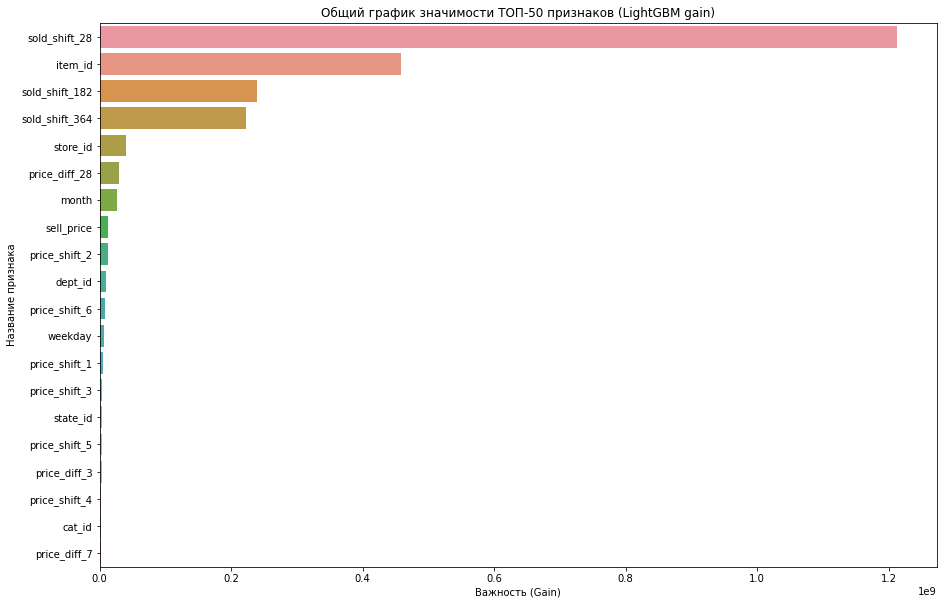

In [25]:
plt.figure(figsize=(15, 10))
sns.barplot(x='values', y='names', data=feature_importances.head(50))
plt.title('Общий график значимости ТОП-50 признаков (LightGBM gain)')
plt.ylabel('Название признака')
plt.xlabel('Важность (Gain)')
plt.show()

# Подготовка "станартного" вида валидации

# Отправка сабмита

In [ ]:
submit_days = only_days_columns(val_pred)
submit_evaluation = val_pred[['id'] + submit_days]
submit_rename_dict = {
    col: f'F{i}' 
    for i, col in enumerate(only_days_columns(submit_evaluation), start=1)
}
submit_evaluation = submit_evaluation.rename(columns=submit_rename_dict)

submit_validation = submit_evaluation.copy()
submit_validation['id'] = submit_validation.id.str.replace('evaluation', 'validation')

submit = pd.concat([submit_evaluation, submit_validation])

In [ ]:
submit.to_csv('submit.csv', index=False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submit.csv -m "Test price"